In [69]:
import pickle
import pandas as pd
import numpy as np
import psycopg2
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from xgboost import plot_importance
import category_encoders as ce
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sb

In [3]:
with open('../sql_id.txt', 'r') as f:
    cred = [x.replace("'", '').strip() for x in f]
    dbname = cred[0]
    username = cred[1]
    pswd = cred[2]
    
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

In [4]:
def qual_encode(qual):
    
    qual_list = ['Masters','MBA','PhD','J.D.']
    qual_encodings = {'Masters': 5, 'MBA': 5, 'PhD': 20, 'J.D.': 30}
    if qual in qual_list:
        return qual_encodings[qual]
    else:
        return 0
    
def get_exp(bio):
    
    if 'years' in bio:
        yrs = np.array([int(i) for i in re.findall('\d+', bio)])
        if len(yrs[yrs<50])>0:
            return max(yrs[yrs<50])
        else:
            return 0
    else:
        return 0
    
def get_exp_text(bio):
    
    numbers = ['one','two','three','four','five','six','seven','eight','nine','ten','eleven','twelve',
          'thirteen','fourteen','fifteen','sixteen','seventeen','eighteen','nineteen','twenty','thirty',
          'forty','fifty']
    numbers_dict = {'one':1,'two':2,'three':3,'four':4,'five':5,'six':6,'seven':7,'eight':8,'nine':9,'ten':10,
                'eleven':11,'twelve':12, 'thirteen':13,'fourteen':14,'fifteen':15,'sixteen':16,'seventeen':17,
                'eighteen':18,'nineteen':19,'twenty':20,'thirty':30,'forty':40,'fifty':50}
    
    if any(x in bio.lower() for x in numbers):
        matches = [x for x in numbers if x in bio.lower()]
        return sum([numbers_dict[x] for x in matches])
    else:
        return 0

In [5]:
sql_query = """
SELECT * FROM tutor_main
"""
tutor_data = pd.read_sql_query(sql_query,con)
tutor_data = pd.read_sql_query(sql_query,con)
tutor_data = tutor_data.drop_duplicates(subset='tut_id').reset_index(drop=True)
tutor_data['log_hourly_rate'] = np.log(tutor_data['hourly_rate'])
tutor_data['qual_encoded'] = tutor_data.apply(lambda x: qual_encode(x['qual_1']) + qual_encode(x['qual_2']), axis =1) 
tutor_data.head()

,index,description,hourly_rate,bio,background_check,tut_id,photo,rating_count,rating_av,review_count,...,sunday_hours,monday_hours,tuesday_hours,wednesday_hours,thursday_hours,friday_hours,saturday_hours,mean_hours,log_hourly_rate,qual_encoded
0,0,Fun Experienced Tutor!,60,"['Hi!', ""I'm an experienced tutor with a sense...",1,7269032,1,269,4.98885,15.0,...,0.583333,0.416667,0.583333,0.375000,0.375000,0.583333,0.583333,0.500000,4.094345,5
1,1,"Math, Writing and Econ Specialist, 8+ Years Tu...",75,"['From Algebra to MLA, Middle School to MBA, I...",1,7277990,1,338,4.93195,18.0,...,0.500000,0.541667,0.583333,0.583333,0.583333,0.500000,0.333333,0.517857,4.317488,5
2,2,Top-Rated Test Prep (SAT / ACT / ISEE / HSPT) ...,95,"[""I am an experienced (3000+ hours) tutor cert...",1,7611743,1,1046,4.94349,74.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.553877,0
3,3,Congratulations to my students entering Harvar...,95,['MARCH 2020: IN ORDER TO ASSIST MORE STUDENTS...,1,7614535,1,1602,4.97940,32.0,...,0.000000,0.375000,0.541667,0.541667,0.250000,0.416667,0.375000,0.357143,4.553877,5
4,13,"Patient, Knowledgeable and Effective Spanish T...",125,['I am a high school AP Spanish Language teach...,1,8022035,1,67,4.98507,12.0,...,0.041667,0.166667,0.083333,0.125000,0.125000,0.083333,0.000000,0.089286,4.828314,0


In [6]:
ivys = 'Brown|Columbia|Dartmouth|Harvard|Cornell|Pennsylvania|Princeton|Yale'

tutor_data['all_ed'] = tutor_data['inst_1'] + ' ' + tutor_data['inst_2'] + ' ' + tutor_data['inst_3']
tutor_data['ivy_1e'] = tutor_data['inst_1'].str.contains(ivys).astype(int)
tutor_data['ivy_2e'] = tutor_data['inst_2'].str.contains(ivys).astype(int)
tutor_data['ivy_3e'] = tutor_data['inst_3'].str.contains(ivys).astype(int)
tutor_data['ivy_tot'] = tutor_data['ivy_1e']+tutor_data['ivy_2e']+tutor_data['ivy_3e']

tutor_data['state_1e'] = tutor_data['inst_1'].str.contains('State').astype(int)
tutor_data['state_2e'] = tutor_data['inst_2'].str.contains('State').astype(int)
tutor_data['state_3e'] = tutor_data['inst_3'].str.contains('State').astype(int)
tutor_data['state_tot'] = tutor_data['state_1e']+tutor_data['state_2e']+tutor_data['state_3e']
tutor_data['experience'] = tutor_data['bio'].apply(get_exp)
tutor_data['exptext'] = tutor_data['bio'].apply(get_exp_text)
tutor_data['exp_tot'] = tutor_data['experience'] + tutor_data['exptext']

In [7]:
loaded_model = pickle.load(open('model_xgb2.sav', 'rb'))
loaded_encodings = pickle.load(open('cbenc2.pkl', 'rb'))
tfidf_sub = pickle.load(open('tfidf.sav', 'rb'))
tfidf_ed = pickle.load(open('tfidf_ed.sav', 'rb'))
subPCA = pickle.load(open('subPCA.pkl', 'rb'))
edPCA = pickle.load(open('edPCA.pkl', 'rb'))
kmeans = pickle.load(open('kmeans_16.sav', 'rb'))

In [8]:
len(tutor_data)

15867

In [9]:
text_ed = tfidf_ed.transform(tutor_data['all_ed'])
ed_df = pd.DataFrame(edPCA.transform(text_ed.todense()))
ed_df = ed_df.rename(columns={0 : 'ed_0', 1:'ed_1'})

tutor_data['ed_0'] = ed_df['ed_0']
tutor_data['ed_1'] = ed_df['ed_1']

In [10]:
sql_query = """
SELECT * FROM tutor_subjects
"""
tutor_subjects = pd.read_sql_query(sql_query,con)
tutors_joined = tutor_subjects.groupby('tutor_ids')['subjects'].apply(list).reset_index()
tutors_joined['subjects'] = tutors_joined['subjects'].apply(set)
tutors_joined['subjects'] = tutors_joined['subjects'].apply(list)
tutors_joined['subjects_joined'] = tutors_joined.apply(lambda x: (' ').join(x['subjects']), axis=1)
tutors_joined['tutor_ids']=tutors_joined['tutor_ids'].apply(float)
tutors_joined['tutor_ids']=tutors_joined['tutor_ids'].apply(int)
tutors_joined.head()

,tutor_ids,subjects,subjects_joined
0,10319,"[Statistics, SAT Reading, GRE, Probability, AC...",Statistics SAT Reading GRE Probability ACT Eng...
1,10380,"[SAT Math, Writing, Algebra 1, Precalculus, Ge...",SAT Math Writing Algebra 1 Precalculus Geometr...
2,10504,"[C++, ASVAB, SAT Math, GED, Visual Basic, Elem...",C++ ASVAB SAT Math GED Visual Basic Elementary...
3,10675,"[Discrete Math, Organic Chemistry, Linear Alge...",Discrete Math Organic Chemistry Linear Algebra...
4,10733,"[Literature, ESL/ESOL, Vocabulary, Proofreadin...",Literature ESL/ESOL Vocabulary Proofreading Re...


In [11]:
#stopWords = [] 
#
#tfidf_sub = TfidfVectorizer(
#    min_df = 5,
#    max_df = 0.95,
#    max_features = 20000,
#    stop_words = stopWords,
#    ngram_range = (1,2)
#)
#tfidf_sub.fit(tutors_joined['subjects_joined'])

In [12]:
cat_features = ['state','ivy_1e','ivy_2e','ivy_3e']
all_features = ['state','qual_encoded','num_subjects','hours_tutoring','edu_length',
                'rating_count','review_count','rating_av','bio_length',
                'sunday_hours','monday_hours','tuesday_hours','wednesday_hours','thursday_hours','friday_hours',
                'saturday_hours','ivy_1e','ivy_2e','ivy_3e','experience','hourly_rate','sub_0','sub_1','sub_2',
                'sub_3','sub_4','ed_0','ed_1','log_hourly_rate','exptext','exp_tot']
num_features = ['num_subjects','hours_tutoring','edu_length', 'rating_count', 'rating_av','review_count',
                'sunday_hours','monday_hours','tuesday_hours','wednesday_hours','thursday_hours','friday_hours',
                'saturday_hours','experience','bio_length','hourly_rate','sub_0','sub_1','sub_2',
                'sub_3','sub_4','ed_0','ed_1','exptext','exp_tot']

In [13]:
text_sub = tfidf_sub.transform(tutors_joined['subjects_joined'])

subjects_df = pd.DataFrame(subPCA.transform(text_sub.todense()))
subjects_df = subjects_df.rename(columns={0 : 'sub_0', 1:'sub_1',2: 'sub_2',3:'sub_3',4:'sub_4'})

In [14]:
tdf = tutors_joined.join(subjects_df).drop_duplicates(subset='tutor_ids').reset_index(drop=True)
tutors_tfidf = pd.merge(tutor_data,tdf,left_on = 'tut_id',right_on = 'tutor_ids')[all_features]

tutors_outliers = tutors_tfidf[(tutors_tfidf['log_hourly_rate']<6) 
                               & (tutors_tfidf['log_hourly_rate']>2.5)]
                             # & (tutors_tfidf['state'])]
                    
tutors_outliers = tutors_outliers.drop('hourly_rate',axis=1)

In [15]:
cbenc = ce.CatBoostEncoder(cols=cat_features, random_state=1)

In [66]:
X = tutors_outliers.drop('log_hourly_rate', axis=1)

y = tutors_outliers['log_hourly_rate']

model_xgb = XGBRegressor(n_estimators=600, max_depth = 5, learning_rate=0.03, random_state=1)

train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state = 1)

cbenc.fit(train_X[cat_features], train_y)

train_X = train_X.join(cbenc.transform(train_X[cat_features]).add_suffix('_cb'))
train_X = train_X.drop(cat_features,axis=1)
val_X = val_X.join(cbenc.transform(val_X[cat_features]).add_suffix('_cb'))
val_X = val_X.drop(cat_features,axis=1)

model_xgb.fit(train_X.values, train_y.values)

preds_val = model_xgb.predict(val_X.values)
mae = mean_absolute_error(np.exp(val_y.values), np.exp(preds_val))

print(mae)
print(model_xgb.score(val_X.values,val_y.values))

13.266057561487619
0.20663707398350703


In [67]:
preds_val_train = model_xgb.predict(train_X.values)
mae = mean_absolute_error(np.exp(train_y.values), np.exp(preds_val_train))

print(mae)
print(model_xgb.score(train_X.values,train_y.values))

10.905289106050398
0.4660375597459221


In [27]:
train_X.columns

Index(['qual_encoded', 'num_subjects', 'hours_tutoring', 'edu_length',
       'rating_count', 'review_count', 'rating_av', 'bio_length',
       'sunday_hours', 'monday_hours', 'tuesday_hours', 'wednesday_hours',
       'thursday_hours', 'friday_hours', 'saturday_hours', 'experience',
       'sub_0', 'sub_1', 'sub_2', 'sub_3', 'sub_4', 'ed_0', 'ed_1', 'exptext',
       'exp_tot', 'state_cb', 'ivy_1e_cb', 'ivy_2e_cb', 'ivy_3e_cb'],
      dtype='object')

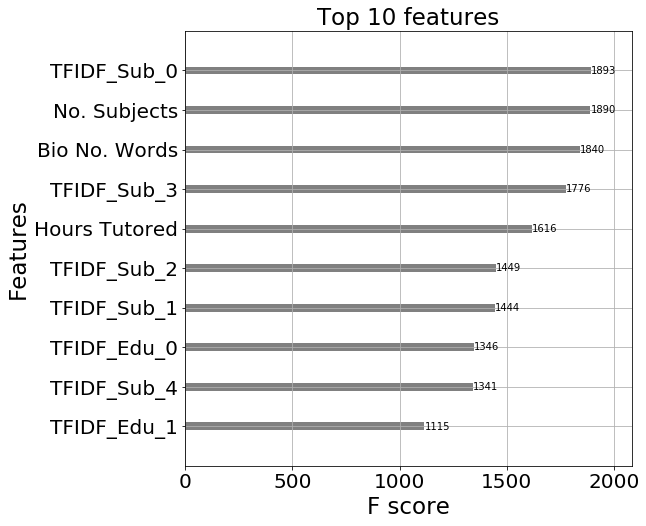

In [37]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

fig, ax = plt.subplots(figsize=(8, 8))

#c = plot_importance(model_xgb,max_num_features=10,ax=ax,color='gray')
c = plot_importance(model_xgb,max_num_features=10,ax=ax,color='gray')

#c.set_yticklabels(['TFIDF_Sub_0','No. Subjects','Bio No. Words', 'TFIDF_Sub_3',
#                                            'Hours Tutored', 'TFIDF_Sub_2', 'TFIDF_Sub_1', 'TFIDF_Edu_0',
#                                           'TFIDF_Sub_4','TFIDF_Edu_1'])
c.set_yticklabels(['TFIDF_Edu_1','TFIDF_Sub_4','TFIDF_Edu_0', 'TFIDF_Sub_1',
                                            'TFIDF_Sub_2', 'Hours Tutored', 'TFIDF_Sub_3', 'Bio No. Words',
                                           'No. Subjects','TFIDF_Sub_0'])
c.set_xlabel("F score",fontsize=23)
c.set_ylabel("Features",fontsize=23)
c.set_title("Top 10 features",fontsize=23)
plt.savefig("/home/codonnell/feat_imp.png")

In [16]:
val_X.head()

,qual_encoded,num_subjects,hours_tutoring,edu_length,rating_count,review_count,rating_av,bio_length,sunday_hours,monday_hours,...,sub_3,sub_4,ed_0,ed_1,exptext,exp_tot,state_cb,ivy_1e_cb,ivy_2e_cb,ivy_3e_cb
3405,0,24,44.0,4,16,3.0,5.00000,369,0.500000,0.500000,...,0.105185,0.091027,-0.076790,0.229000,21,22,3.912955,3.816676,3.818395,3.823404
6519,0,25,0.0,4,0,0.0,0.00000,422,0.125000,0.000000,...,0.103180,0.010404,-0.040342,0.017762,1,1,3.738205,3.816676,3.818395,3.823404
7219,20,9,175.0,10,48,2.0,4.79167,112,0.000000,0.000000,...,-0.058066,-0.197701,-0.019010,-0.038862,1,1,3.912955,3.816676,4.105884,3.823404
6915,0,11,2.0,7,1,0.0,5.00000,367,0.583333,0.583333,...,-0.172205,-0.008861,-0.023521,-0.043466,0,5,3.912955,4.072401,3.818395,3.823404
1420,0,80,31.0,1,7,1.0,5.00000,403,0.541667,0.541667,...,-0.091974,0.117615,-0.015581,-0.029421,11,11,3.912955,3.816676,3.818395,3.823404


In [17]:
def assign_cluster(kmeans, tfidf, subjects):
    '''Returns the closest cluster for a given string of subjects''' 
    
    centroids = kmeans.cluster_centers_
    diff =  centroids - np.array(tfidf.transform(subjects).todense())
    return np.argmin(np.array([np.linalg.norm(d) for d in diff]))

In [18]:
tdf['cluster'] = tdf.apply(lambda x: assign_cluster(kmeans, tfidf_sub, [x['subjects_joined']]), axis=1)

In [82]:
val_X_id = val_X.merge(tutor_data['tut_id'].to_frame(), left_index=True, right_index=True)

val_X_joined = pd.merge(val_X_id,tdf,left_on = 'tut_id',right_on = 'tutor_ids')
# get original subject list, join
# apply sql lookup

In [20]:
#val_X_joined = val_X_joined.drop(['sub_0_y','sub_1_y', 'sub_2_y', 'sub_3_y',
#                                 'sub_4_y','tut_id','tutor_ids'],axis=1)

val_X_joined.head()

,qual_encoded,num_subjects,hours_tutoring,edu_length,rating_count,review_count,rating_av,bio_length,sunday_hours,monday_hours,...,tut_id,tutor_ids,subjects,subjects_joined,sub_0_y,sub_1_y,sub_2_y,sub_3_y,sub_4_y,cluster
0,0,24,44.0,4,16,3.0,5.00000,369,0.500000,0.500000,...,9731336,9731336,"[Precalculus, Algebra 1, Common Core, Physics,...",Precalculus Algebra 1 Common Core Physics ACT ...,0.162301,-0.056756,0.084555,0.105185,0.091027,13
1,0,25,0.0,4,0,0.0,0.00000,422,0.125000,0.000000,...,9618840,9618840,"[Common Core, Public Speaking, Reading, Gramma...",Common Core Public Speaking Reading Grammar Wr...,-0.207461,-0.036879,-0.061838,0.103180,0.010404,15
2,20,9,175.0,10,48,2.0,4.79167,112,0.000000,0.000000,...,8319420,8319420,"[Literature, Vocabulary, Proofreading, French,...",Literature Vocabulary Proofreading French ESL/...,-0.205914,0.091582,-0.081611,-0.058066,-0.197701,3
3,0,11,2.0,7,1,0.0,5.00000,367,0.583333,0.583333,...,9628618,9628618,"[Algebra 1, Chemistry, ACT Reading, Biology, M...",Algebra 1 Chemistry ACT Reading Biology MCAT S...,-0.083972,-0.087873,-0.097227,-0.172205,-0.008861,0
4,0,80,31.0,1,7,1.0,5.00000,403,0.541667,0.541667,...,9770661,9770661,"[Precalculus, Organic Chemistry, Public Speaki...",Precalculus Organic Chemistry Public Speaking ...,0.005754,-0.109622,0.126258,-0.091974,0.117615,0


In [79]:
def new_sub_list(orig_subs, cluster):
    
    sql_query = """
        SELECT clus_""" + str(cluster) + """ FROM real_subjs_df
        ;
        """
    pop_subjs_sql = pd.read_sql_query(sql_query,con)
    
    ndarr = pop_subjs_sql.values.tolist()
    pop_flat = [x for sublist in ndarr for x in sublist]
    missing_subs = [item for item in pop_flat if item not in orig_subs]
    missing_subs = [i for i in missing_subs if i]

    if len(missing_subs) >= 10:
        missing_subs = missing_subs[:10]
        return (' ').join(orig_subs + missing_subs)
        #return orig_subs + missing_subs
    elif len(missing_subs) ==0:
        return (' ').join(orig_subs)
    elif len(orig_subs) ==0:
        return []
    else:
        return (' ').join(orig_subs + missing_subs)
        #return orig_subs + missing_subs

In [80]:
def new_num_subs(orig_subs, cluster):
    
    sql_query = """
        SELECT clus_""" + str(cluster) + """ FROM real_subjs_df
        ;
        """
    pop_subjs_sql = pd.read_sql_query(sql_query,con)
    
    ndarr = pop_subjs_sql.values.tolist()
    pop_flat = [x for sublist in ndarr for x in sublist]
    missing_subs = [item for item in pop_flat if item not in orig_subs]
    missing_subs = [i for i in missing_subs if i]

    if len(missing_subs) >= 10:
        missing_subs = missing_subs[:10]
        
    return len(orig_subs) + len(missing_subs)

In [36]:
orig_subs = val_X_joined['subjects'].iloc[0]
clus = val_X_joined['cluster'].iloc[0]

orig_subs = orig_subs.split(' ')
sql_query = """
    SELECT clus_""" + str(clus) + """ FROM pop_subjects_weighted
    ;
    """
pop_subjs_sql = pd.read_sql_query(sql_query,con)
    
ndarr = pop_subjs_sql.values.tolist()
pop_flat = [x for sublist in ndarr for x in sublist]
missing_subs = [item for item in pop_flat if item not in orig_subs]

if len(missing_subs) >= 10:
    missing_subs = missing_subs[:10]
        
num_subjects_new = len(orig_subs) + len(missing_subs)

In [35]:
len([])

0

In [83]:
val_X_joined['new_num_subs'] = val_X_joined.apply(lambda x: new_num_subs(x['subjects'],x['cluster']),axis=1)
val_X_joined['new_subs_joined'] = val_X_joined.apply(lambda x: new_sub_list(x['subjects'],x['cluster']),axis=1)

In [84]:
val_X_joined.head()

,qual_encoded,num_subjects,hours_tutoring,edu_length,rating_count,review_count,rating_av,bio_length,sunday_hours,monday_hours,...,subjects,subjects_joined,sub_0_y,sub_1_y,sub_2_y,sub_3_y,sub_4_y,cluster,new_num_subs,new_subs_joined
0,0,24,44.0,4,16,3.0,5.00000,369,0.500000,0.500000,...,"[Precalculus, Algebra 1, Common Core, Physics,...",Precalculus Algebra 1 Common Core Physics ACT ...,0.162301,-0.056756,0.084555,0.105185,0.091027,13,34,Precalculus Algebra 1 Common Core Physics ACT ...
1,0,25,0.0,4,0,0.0,0.00000,422,0.125000,0.000000,...,"[Common Core, Public Speaking, Reading, Gramma...",Common Core Public Speaking Reading Grammar Wr...,-0.207461,-0.036879,-0.061838,0.103180,0.010404,15,35,Common Core Public Speaking Reading Grammar Wr...
2,20,9,175.0,10,48,2.0,4.79167,112,0.000000,0.000000,...,"[Literature, Vocabulary, Proofreading, French,...",Literature Vocabulary Proofreading French ESL/...,-0.205914,0.091582,-0.081611,-0.058066,-0.197701,3,19,Literature Vocabulary Proofreading French ESL/...
3,0,11,2.0,7,1,0.0,5.00000,367,0.583333,0.583333,...,"[Algebra 1, Chemistry, ACT Reading, Biology, M...",Algebra 1 Chemistry ACT Reading Biology MCAT S...,-0.083972,-0.087873,-0.097227,-0.172205,-0.008861,0,21,Algebra 1 Chemistry ACT Reading Biology MCAT S...
4,0,80,31.0,1,7,1.0,5.00000,403,0.541667,0.541667,...,"[Precalculus, Organic Chemistry, Public Speaki...",Precalculus Organic Chemistry Public Speaking ...,0.005754,-0.109622,0.126258,-0.091974,0.117615,0,88,Precalculus Organic Chemistry Public Speaking ...


In [85]:
val_X_joined = val_X_joined.drop(['sub_0_y','sub_1_y', 'sub_2_y', 'sub_3_y',
                                 'sub_4_y','tut_id','tutor_ids','cluster'],axis=1)

In [86]:
text_sub_new = tfidf_sub.transform(val_X_joined['new_subs_joined'])

subjects_df_new = pd.DataFrame(subPCA.transform(text_sub_new.todense()))
subjects_df_new = subjects_df_new.rename(columns={0 : 'sub_0', 1:'sub_1',2: 'sub_2',3:'sub_3',4:'sub_4'})

In [87]:
val_X_joined['num_subjects']=val_X_joined['new_num_subs']

val_X_joined = val_X_joined.drop(['sub_0_x','sub_1_x', 'sub_2_x', 'sub_3_x',
                                 'sub_4_x','subjects','subjects_joined','new_num_subs','new_subs_joined'],axis=1)
val_X_joined['sub_0']=subjects_df_new['sub_0']
val_X_joined['sub_1']=subjects_df_new['sub_1']
val_X_joined['sub_2']=subjects_df_new['sub_2']
val_X_joined['sub_3']=subjects_df_new['sub_3']
val_X_joined['sub_4']=subjects_df_new['sub_4']

In [88]:
val_X_joined.head()

,qual_encoded,num_subjects,hours_tutoring,edu_length,rating_count,review_count,rating_av,bio_length,sunday_hours,monday_hours,...,exp_tot,state_cb,ivy_1e_cb,ivy_2e_cb,ivy_3e_cb,sub_0,sub_1,sub_2,sub_3,sub_4
0,0,34,44.0,4,16,3.0,5.00000,369,0.500000,0.500000,...,22,3.912955,3.816676,3.818395,3.823404,0.145817,-0.059239,0.076846,0.080815,0.088796
1,0,35,0.0,4,0,0.0,0.00000,422,0.125000,0.000000,...,1,3.738205,3.816676,3.818395,3.823404,-0.161558,-0.031686,-0.051438,0.098233,-0.000420
2,20,19,175.0,10,48,2.0,4.79167,112,0.000000,0.000000,...,1,3.912955,3.816676,4.105884,3.823404,-0.105836,0.151099,-0.056796,-0.022818,-0.099512
3,0,21,2.0,7,1,0.0,5.00000,367,0.583333,0.583333,...,5,3.912955,4.072401,3.818395,3.823404,-0.111063,-0.075829,-0.062619,-0.077767,-0.019766
4,0,88,31.0,1,7,1.0,5.00000,403,0.541667,0.541667,...,11,3.912955,3.816676,3.818395,3.823404,-0.014965,-0.116992,0.123837,-0.058365,0.114288


In [89]:
val_X.columns

Index(['qual_encoded', 'num_subjects', 'hours_tutoring', 'edu_length',
       'rating_count', 'review_count', 'rating_av', 'bio_length',
       'sunday_hours', 'monday_hours', 'tuesday_hours', 'wednesday_hours',
       'thursday_hours', 'friday_hours', 'saturday_hours', 'experience',
       'sub_0', 'sub_1', 'sub_2', 'sub_3', 'sub_4', 'ed_0', 'ed_1', 'exptext',
       'exp_tot', 'state_cb', 'ivy_1e_cb', 'ivy_2e_cb', 'ivy_3e_cb'],
      dtype='object')

In [90]:
val_X_joined = val_X_joined[['qual_encoded', 'num_subjects', 'hours_tutoring', 'edu_length',
       'rating_count', 'review_count', 'rating_av', 'bio_length',
       'sunday_hours', 'monday_hours', 'tuesday_hours', 'wednesday_hours',
       'thursday_hours', 'friday_hours', 'saturday_hours', 'experience',
       'sub_0', 'sub_1', 'sub_2', 'sub_3', 'sub_4', 'ed_0', 'ed_1', 'exptext',
       'exp_tot', 'state_cb', 'ivy_1e_cb', 'ivy_2e_cb', 'ivy_3e_cb']]

In [91]:
preds_val_new = model_xgb.predict(val_X_joined.values)

In [92]:
diff = (np.exp(preds_val_new)-np.exp(preds_val))

In [93]:
np.mean(diff[diff>0])

1.7319751

In [40]:
scaler = StandardScaler()

In [53]:
X = tutors_outliers.drop('log_hourly_rate', axis=1)

y = tutors_outliers['log_hourly_rate']

model_lin = Ridge(alpha=0.001)

train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state = 1)

cbenc.fit(train_X[cat_features], train_y)

train_X = train_X.join(cbenc.transform(train_X[cat_features]).add_suffix('_cb'))
train_X = train_X.drop(cat_features,axis=1)
val_X = val_X.join(cbenc.transform(val_X[cat_features]).add_suffix('_cb'))
val_X = val_X.drop(cat_features,axis=1)

model_lin.fit(train_X.values, train_y.values)

preds_val = model_lin.predict(val_X.values)
mae = mean_absolute_error(np.exp(val_y.values), np.exp(preds_val))

print(mae)
print(model_lin.score(val_X,val_y))

13.662769012462366
0.15499362842476316


In [46]:
print(model_lin.score(val_X,val_y))

0.15499346070141928


In [55]:

X = tutors_outliers.drop('log_hourly_rate', axis=1)

y = tutors_outliers['log_hourly_rate']

model_forest = RandomForestRegressor(criterion = 'mae' , random_state=1)

train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state = 1)

cbenc.fit(train_X[cat_features], train_y)

train_X = train_X.join(cbenc.transform(train_X[cat_features]).add_suffix('_cb'))
train_X = train_X.drop(cat_features,axis=1)
val_X = val_X.join(cbenc.transform(val_X[cat_features]).add_suffix('_cb'))
val_X = val_X.drop(cat_features,axis=1)

model_forest.fit(train_X.values, train_y.values)

preds_val = model_forest.predict(val_X.values)
mae = mean_absolute_error(np.exp(val_y.values), np.exp(preds_val))

print(mae)
print(model_forest.score(val_X,val_y))

KeyboardInterrupt: 